## import

In [1]:
seed = 42

# Import libraries
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

import random
random.seed(seed)
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score, precision_recall_curve, auc, confusion_matrix
from imblearn.over_sampling import SMOTE

from sklearn.feature_selection import mutual_info_classif, SelectKBest, SelectPercentile, f_classif, f_regression, SelectFromModel
from scipy.spatial.distance import pdist, squareform
from scipy.stats import ttest_ind
from xgboost import XGBClassifier
import statistics
from sklearn.decomposition import PCA
from sklearn.metrics import balanced_accuracy_score

import pickle

## caricamento dati

### caricamento labels pazienti

In [2]:

file_path = "../CSV/data_rad_clin_DEF.csv"

data = pd.read_csv(file_path)
labels_column = data['label']
labels = labels_column.astype(int).tolist()

labels=np.array(labels)

# Estrazione dei numeri dai nomi dei pazienti
loaded_patients = data['IDs_new'].str.extract(r'(\d+)').astype(int).squeeze().tolist()

print("Labels:", labels)
print("Number of labels:", len(labels))
print("Patient Names: ", loaded_patients )




Labels: [0 1 1 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 1 0 1 0
 0 0 1 1 0 0 1 0 1 1 1 1 1 0 0 0 1 0 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 1 0 0
 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0
 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1]
Number of labels: 129
Patient Names:  [5, 12, 15, 16, 17, 19, 22, 23, 24, 25, 26, 27, 29, 30, 31, 33, 35, 36, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 50, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 64, 65, 68, 69, 70, 71, 74, 75, 76, 78, 79, 81, 82, 84, 85, 86, 87, 88, 89, 90, 91, 92, 94, 95, 96, 98, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 123, 124, 126, 127, 128, 129, 133, 135, 136, 137, 138, 139, 141, 142, 144, 146, 147, 149, 150, 153, 155, 158, 159, 161, 163, 166, 168, 169, 170, 171, 175, 176, 178, 182, 183, 188, 189, 190, 193, 197, 199, 200, 205]


### caricamento features encoder

In [295]:
###### encoders imagenet e immagine annerita      1A
#file_path_encoder = "../CSV/EncodersSliceMaggiore/VGG19_Slice_Maggiore.csv"
#file_path_encoder = "../CSV/EncodersSliceMaggiore/InceptionV3_Slice_Maggiore.csv"
#file_path_encoder = "../CSV/EncodersSliceMaggiore/RESNET50_Slice_Maggiore.csv"

############  encoders nuovi medici e immagine non annerita    2B
#file_path_encoder = "../CSV/EncodersNuoviPesi/INCEPTION_SliceMaggiore_NuoviPesi_secondaversione.csv"
#file_path_encoder = "../CSV/EncodersNuoviPesi/ResNet50_SliceMaggiore_NuoviPesi_secondaversione.csv"
#file_path_encoder = "../CSV/EncodersNuoviPesi/INCRES_SliceMaggiore_NuoviPesi_secondaversione.csv"

############### encoders imagenet e immagine non annerita      1B
#file_path_encoder = "../CSV/EncodersImagenet/INCEPTIONV3_SliceMaggiore_Imagenet_secondaversione.csv"
#file_path_encoder = "../CSV/EncodersImagenet/RESNET50_SliceMaggiore_Imagenet_secondaversione.csv"
#file_path_encoder = "../CSV/EncodersImagenet/VGG19_SliceMaggiore_Imagenet_secondaversione.csv" ## 6 features lasciate dal p-value
 
########### encoders nuovi e immagine non annerita e NON TAGLIATA NON NORMALIZZATA
#file_path_encoder = "../CSV/EncodersFullImageNuoviPesi/RESNET50_SliceMaggiore_NuoviPesi_fullimage.csv" ## 22 features lasciate dal p value
#file_path_encoder = "../CSV/EncodersFullImageNuoviPesi/INCEPTIONV3_SliceMaggiore_NuoviPesi_fullimage.csv" ## 21 features lasciate dal p value
#file_path_encoder = "../CSV/EncodersFullImageNuoviPesi/INCRES_SliceMaggiore_NuoviPesi_fullimage.csv" ## 45 features lasciate dal p value

########### encoders nuovi e immagine non annerita e NON TAGLIATA  NORMALIZZATA!    2C
#file_path_encoder = "../CSV/EncodersFullImageNuoviPesiNormalized/RESNET50_SliceMaggiore_NuoviPesi_fullimage_normalized.csv"
#file_path_encoder = "../CSV/EncodersFullImageNuoviPesiNormalized/INCEPTIONV3_SliceMaggiore_NuoviPesi_fullimage_normalized.csv"
#file_path_encoder = "../CSV/EncodersFullImageNuoviPesiNormalized/INCRES_SliceMaggiore_NuoviPesi_fullimage_normalized.csv"

########### encoders nuovi e immagine annerita    2A
#file_path_encoder = "../CSV/EncoderNuovoImgNera/RESNET50_SliceMaggiore_NuoviPesi_annerita.csv"
#file_path_encoder = "../CSV/EncoderNuovoImgNera/INCRES_SliceMaggiore_NuoviPesi_annerita.csv"
file_path_encoder = "../CSV/EncoderNuovoImgNera/INCEPTIONV3_SliceMaggiore_NuoviPesi_annerita.csv"


########### encoder imagenet e immagine intera normalizzata    1C
#file_path_encoder = "../CSV/EncodersImagenetFullImage/VGG19_SingolaSlice_Imagenet_fullimage.csv"
#file_path_encoder = "../CSV/EncodersImagenetFullImage/RESNET50_SingolaSlice_Imagenet_fullimage.csv"
#file_path_encoder = "../CSV/EncodersImagenetFullImage/INCEPTIONV3_SingolaSlice_Imagenet_fullimage.csv"

df = pd.read_csv(file_path_encoder, sep=',')

df['Unnamed: 0'] = df['Unnamed: 0'].astype(int)

df_ordered = df.set_index('Unnamed: 0').loc[loaded_patients].reset_index()

df_features = df_ordered.drop(columns=['Unnamed: 0'])

features = df_features.to_numpy()

print(features)
print(features.shape)


[[0.         0.17528395 0.47440505 ... 0.         0.4245674  0.        ]
 [0.32647315 0.         0.         ... 0.         0.2563182  0.        ]
 [0.03145011 0.18880549 0.49038386 ... 0.         0.8111149  0.        ]
 ...
 [0.10235861 0.1954091  0.13813075 ... 0.         0.29090977 0.        ]
 [0.15914479 0.         0.         ... 0.         0.0806156  0.        ]
 [0.         0.22181    0.         ... 0.         0.24751337 0.        ]]
(129, 2048)


### caricamento features radiomica

In [307]:
file_path = "../CSV/EncodersSliceMaggiore/Radiomica_Wavelet_2D.csv"
#file_path = "../CSV/EncodersSliceMaggiore/Radiomica_2D.csv"

df = pd.read_csv(file_path, sep=',')
#df = df.astype(float)

# Colonne da rimuovere SOLO PER RADIOMICA
columns_to_remove = [
    'Slice',
    'diagnostics_Image-original_Mean',
    'diagnostics_Image-original_Minimum',
    'diagnostics_Image-original_Maximum',
    'diagnostics_Mask-original_VoxelNum',
    'diagnostics_Mask-original_VolumeNum',
]

df_cleaned = df.drop(columns=columns_to_remove)
df_features = df_cleaned.drop(columns=['Paziente'])

features = df_features.to_numpy()

print(features)
print(features.shape)  

[[5.83888273e-01 2.49810487e+01 2.57099203e+01 ... 5.69700030e+03
  5.01293376e-01 1.88681815e+02]
 [8.68120272e-01 2.78353641e+01 2.75136330e+01 ... 1.17856494e+04
  4.99502216e-01 2.32884640e+02]
 [6.68428011e-01 3.34967625e+01 3.44818793e+01 ... 1.10016612e+03
  1.37685835e-01 1.17271924e+02]
 ...
 [8.95387032e-01 3.24479655e+01 2.80178515e+01 ... 3.74357530e+02
  3.76839859e-01 4.56595117e+01]
 [7.82116308e-01 2.65896102e+01 2.56320112e+01 ... 1.71247332e+04
  8.63664634e-01 1.86559244e+02]
 [5.58702485e-01 3.61138047e+01 3.58468967e+01 ... 1.35620356e+04
  4.73861210e-01 2.66695842e+02]]
(129, 474)


### caricamento pesi da autoencoder

In [4]:
from tensorflow.keras.models import load_model
import h5py
import cv2

def estrai_immagine_massima_area_con_contorno(imagelist):
    """Restituisce l'immagine con l'area più grande delimitata dal contorno di pixel non neri."""
    max_area = 0
    max_image = None

    for image in imagelist:
        # Crea una maschera per i pixel non neri (placca)
        mask = image > 0
        
        # Converti l'immagine in formato che OpenCV può elaborare
        mask_uint8 = mask.astype(np.uint8) * 255

        # Trova i contorni nell'immagine
        contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Considera solo il contorno più grande
        if contours:
            # Trova il contorno con la massima area
            largest_contour = max(contours, key=cv2.contourArea)

            # Calcola l'area del contorno
            area = cv2.contourArea(largest_contour)

            # Aggiorna se questa immagine ha un'area maggiore
            if area > max_area:
                max_area = area
                max_image = image

    return max_image

# Caricamento del file HDF5 con le immagini
h5_file_path = '../images_by_patient_final.h5'
loaded_class_images = []

with h5py.File(h5_file_path, 'r') as h5_file:
    for key in h5_file.keys():
        images = np.array(h5_file[key])
        loaded_class_images.append(images)

# Estrai l'immagine con l'area massima per ciascun paziente usando il nuovo criterio (contorno)
immagini_massime_per_paziente_contorno = []

for imagelist in loaded_class_images:
    max_image = estrai_immagine_massima_area_con_contorno(imagelist)
    immagini_massime_per_paziente_contorno.append(max_image)
    

In [83]:
len(immagini_massime_per_paziente_contorno[0][0])

64

In [76]:


h5_file_path = '../images_by_patient_final.h5'
loaded_class_images=[]

# Apri il file .h5 e carica le immagini in loaded_class_images
with h5py.File(h5_file_path, 'r') as h5_file:
    # Carica ogni gruppo di immagini come un array numpy
    loaded_class_images = {key: np.array(h5_file[key]) for key in h5_file.keys()}

loaded_class_images= {int(key.split('_')[1]): images for key, images in loaded_class_images.items()}

print("Lunghezza array immagini: ", len(loaded_class_images))
print("Shape immagini primo paziente: ", loaded_class_images[0].shape)
print("Shape immagini secondo paziente: ", loaded_class_images[1].shape)

encoder = load_model("../AUTOENCODER/encoder_models/encoder_model32.h5", compile=False)

# Funzione per ottenere le feature da una singola immagine
def get_features_from_image(image):
    image = image.astype('float32')
    image = image / 255.0
    # Ottieni le feature dall'encoder
    if len(image.shape) == 2:  # Se l'immagine è 64x64
        image = np.expand_dims(image, axis=-1)  # Aggiungi canale (per immagini in bianco e nero)
    image = np.expand_dims(image, axis=0)  # Aggiungi dimensione batch
    features = encoder.predict(image, verbose=False)
    features = np.squeeze(features)
    return np.array(features)

# Lista per salvare le feature delle immagini
patients = []

# Ottieni le feature per ogni immagine nella lista
for i in range(len(loaded_class_images)):
    features_list = []
    for img in loaded_class_images[i]:
        features = get_features_from_image(img)
        features_list.append(features)
    fetures_list = np.array(features_list)
    patients.append(features_list)

Lunghezza array immagini:  129
Shape immagini primo paziente:  (28, 64, 64)
Shape immagini secondo paziente:  (22, 64, 64)


KeyboardInterrupt: 

In [ ]:
import h5py
import cv2

def estrai_immagine_massima_area_con_contorno(imagelist):
    """Restituisce l'immagine con l'area più grande delimitata dal contorno di pixel non neri."""
    max_area = 0
    max_image = None

    for image in imagelist:
        # Crea una maschera per i pixel non neri (placca)
        mask = image > 0
        
        # Converti l'immagine in formato che OpenCV può elaborare
        mask_uint8 = mask.astype(np.uint8) * 255

        # Trova i contorni nell'immagine
        contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Considera solo il contorno più grande
        if contours:
            # Trova il contorno con la massima area
            largest_contour = max(contours, key=cv2.contourArea)

            # Calcola l'area del contorno
            area = cv2.contourArea(largest_contour)

            # Aggiorna se questa immagine ha un'area maggiore
            if area > max_area:
                max_area = area
                max_image = image

    return max_image

# Caricamento del file HDF5 con le immagini
h5_file_path = 'images_by_patient_final.h5'
loaded_class_images = []

with h5py.File(h5_file_path, 'r') as h5_file:
    for key in h5_file.keys():
        images = np.array(h5_file[key])
        loaded_class_images.append(images)

# Estrai l'immagine con l'area massima per ciascun paziente usando il nuovo criterio (contorno)
immagini_massime_per_paziente_contorno = []
aree_contorno = []

for imagelist in loaded_class_images:
    max_image, max_area = estrai_immagine_massima_area_con_contorno(imagelist)
    immagini_massime_per_paziente_contorno.append(max_image)
    aree_contorno.append(max_area)

# Calcola anche l'area utilizzando solo i pixel non neri (come facevi prima)
aree_non_nere = []
for imagelist in loaded_class_images:
    max_image = estrai_immagine_massima_area(imagelist)
    non_black_pixels = np.sum(max_image != 0)
    aree_non_nere.append(non_black_pixels)

# Visualizza i risultati
print("Numero di immagini selezionate (una per paziente):", len(immagini_massime_per_paziente_contorno))
print("Shape dell'immagine selezionata per il primo paziente (contorno):", immagini_massime_per_paziente_contorno[0].shape)

# Differenza tra area massimizzata col contorno e solo pixel non neri
differenze_tra_insiemi = np.array(aree_contorno) - np.array(aree_non_nere)

# Visualizza la differenza di aree tra il nuovo metodo e il precedente
for i, diff in enumerate(differenze_tra_insiemi):
    print(f"Diff. area paziente {i+1}: {diff}")


## funzioni

In [4]:

## Rimozione feature correlation
def remove_highly_correlated_features(X, threshold=0.85):
    corr_matrix = np.corrcoef(X, rowvar=False)
    upper_triangle = np.triu(corr_matrix, k=1)
    to_drop = [column for column in range(upper_triangle.shape[0]) if any(abs(upper_triangle[column, :]) > threshold)]
    X_reduced = np.delete(X, to_drop, axis=1)
    return X_reduced, to_drop

## Rimozione features p_value
def remove_high_pvalue_features(X, y, alpha=0.05):
    selector = SelectKBest(score_func=f_classif, k='all')
    selector.fit(X, y)
    p_values = selector.pvalues_
    features_to_keep = np.where(p_values < alpha)[0]
    X_reduced = X[:, features_to_keep]
    return X_reduced, features_to_keep

## FEATURE SELECTION LASSO
def select_features_with_lasso(X, y, alpha=0.001):
    
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    coefficients = lasso.coef_
    selected_features = np.where(coefficients != 0)[0]
    X_selected = X[:, selected_features]

    return X_selected, selected_features

## FEATURE SELECTION LOGISTIC
def logistic_regression_feature_selection(X, y, num_features):
    lr = LogisticRegression(max_iter=2000, random_state=42)
    lr.fit(X, y)
    coef_abs = np.abs(lr.coef_)
    feature_importances = np.mean(coef_abs, axis=0)
    selected_features = feature_importances.argsort()[-num_features:][::-1]
    X_selected = X[:, selected_features]
    return X_selected, selected_features

## FEATURE SELECTION MRMR
def mrmr_feature_selection(X, y, num_features):
    mi = mutual_info_classif(X, y, random_state=42)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    distances = squareform(pdist(X_scaled.T, 'euclidean'))
    
    selected_features = []
    selected_indices = []

    first_feature_index = np.argmax(mi)
    selected_features.append(first_feature_index)
    selected_indices.append(first_feature_index)
    
    for _ in range(num_features - 1):
        max_relevance = -np.inf
        selected_feature_index = -1
        
        for i in range(X.shape[1]):
            if i in selected_indices:
                continue
            
            relevance = mi[i]
            redundancy = np.mean(distances[i, selected_indices])
            
            mrmr_score = relevance - redundancy
            
            if mrmr_score > max_relevance:
                max_relevance = mrmr_score
                selected_feature_index = i
        
        selected_features.append(selected_feature_index)
        selected_indices.append(selected_feature_index)

    X_selected = X[:, selected_indices]
    return X_selected, selected_indices

## FEATURE SELECTION RANDOM FOREST
def rf_feature_selection(X, y, num_features):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    feature_importances = rf.feature_importances_
    selected_features = np.argsort(feature_importances)[-num_features:][::-1]
    X_selected = X[:, selected_features]
    return X_selected, selected_features


## FEATURE SELECTION P_VALUE
# Seleziona e ordina le feature basate sui p-value con un test t di Student poi 
# ordina le feature in base al p-value in ordine crescente e seleziona le prime `num_features` caratteristiche.

def select_features_by_p_value(x_train_expanded, y_train_expanded, num_features):
    p_values = []
    num_features_total = x_train_expanded.shape[1]

    # Calcolo dei p-value per ciascuna feature
    for i in range(num_features_total):
        feature = x_train_expanded[:, i]
        group_0 = feature[y_train_expanded == 0]
        group_1 = feature[y_train_expanded == 1]
        t_stat, p_val = ttest_ind(group_0, group_1, equal_var=False)
        p_values.append(p_val)


    p_values = np.array(p_values)

    # Ordinare tutte le caratteristiche in base ai p-value (dal più piccolo al più grande)
    sorted_indices = np.argsort(p_values)
    sorted_indices = sorted_indices[:num_features]

    x_train_selected = x_train_expanded[:, sorted_indices]

    return x_train_selected, sorted_indices



## FUNZIONE PER RIMUOVERE FEATURES SELEZIONATE
def filter_patients_features(filtered_patients, selected_features):
    filtered_patients_selected = []

    for patient_features in filtered_patients:
        # Select only the features specified in selected_features
        patient_features_selected = patient_features[:, selected_features]
        filtered_patients_selected.append(patient_features_selected)

    return filtered_patients_selected


In [5]:
## classificazione completa che ritorna la threshold migliore per la classificazione
def classification_method(selector, classifier, alpha, x_train_expanded, y_train_expanded, x_test, y_test, num_features, mode="selector", selected_features=[0], thresholds=np.arange(0.4, 0.6, 0.01)):
    best_f1_score = 0
    best_case = None

    if mode == "selector":
            selected_features = None 

        #if num_features != len(x_train_expanded[0]) or alpha != 0:
            if selector == "lasso":
                X_selected, selected_features = select_features_with_lasso(x_train_expanded, y_train_expanded, alpha)
                if(len(selected_features)==0):
                    return 0
            elif selector == "logistic":
                X_selected, selected_features = logistic_regression_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "mrmr":
                X_selected, selected_features = mrmr_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "rf":
                X_selected, selected_features = rf_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "p_value":
                X_selected, selected_features = select_features_by_p_value(x_train_expanded,y_train_expanded, num_features=num_features)
            else:
                print("Wrong selector. Choose between: mrmr, rf, logistic, p_value, lasso")
                return

            x_test = x_test[:, selected_features]  # selezione delle feature anche su x_test
            number_features = len(selected_features)

        #print("Ho scelto le features: ", selected_features)

        # Training del classificatore
            classifier.fit(X_selected, y_train_expanded)

    elif mode == "features":  # Non fa feature selection ma usa le selected_features passate
        if selected_features is None or len(selected_features) == 0:
            print("Error: selected_features must be provided in 'features' mode.")
            return
        
        #print("Testo sulle features:  ", selected_features)
        # Usa solo le selected features su train e test
        X_selected = x_train_expanded[:, selected_features]
        x_test = x_test[:, selected_features]

        number_features = len(selected_features)

        # Training del classificatore su train + validation
        classifier.fit(X_selected, y_train_expanded)
    
    else:
           print("Errore, scegliere tra: selector / features")

    y_proba_test = classifier.predict_proba(x_test)[:, 1]

    if(isinstance(thresholds, np.ndarray)== False): ## se la threshold viene data fissa
        thresholds=[thresholds]
        
    
    for threshold in thresholds:

            y_pred_custom_test = (y_proba_test >= threshold).astype(int)

            accuracy = accuracy_score(y_test, y_pred_custom_test)
            f1 = f1_score(y_test, y_pred_custom_test)
            roc_auc = roc_auc_score(y_test, y_proba_test)

            precision, recall, _ = precision_recall_curve(y_test, y_proba_test)
            pr_auc = auc(recall, precision)

            conf = confusion_matrix(y_test, y_pred_custom_test)
            
            bal_acc = balanced_accuracy_score(y_test, y_pred_custom_test)


            # Se il nuovo risultato è migliore rispetto al migliore attuale (in base all'f1 e altrimenti pr_auc)
            if f1 > best_f1_score or (f1 == best_f1_score and pr_auc > (best_case['pr_auc'] if best_case else 0)):
                best_f1_score = f1
                best_case = {
                    'alpha': alpha,
                    'num_features': number_features,
                    'selected_features': selected_features,
                    'pr_auc': pr_auc,
                    'roc_auc': roc_auc,
                    'f1': f1,
                    'accuracy': accuracy,
                    'confusion_matrix': conf,
                    'best_threshold': threshold,
                    'balanced accuracy': bal_acc
                }

    return best_case


#####################################################################################################################################

### questo ritorna le il vettore di probabilità senza fare la classificazione
def classification_method_withoutThreshold(selector, classifier, alpha, x_train_expanded, y_train_expanded, x_test, y_test, num_features, mode="Val", selected_features=[0]):

    if mode == "Val":
        selected_features = None 

        if num_features != len(x_train_expanded[0]) or alpha != 0:
            if selector == "lasso":
                X_selected, selected_features = select_features_with_lasso(x_train_expanded, y_train_expanded, alpha)
                if (len(selected_features)==0):
                    return [0],0,[0]
            elif selector == "logistic":
                X_selected, selected_features = logistic_regression_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "mrmr":
                X_selected, selected_features = mrmr_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "rf":
                X_selected, selected_features = rf_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "p_value":
                X_selected, selected_features = select_features_by_p_value(x_train_expanded,y_train_expanded, num_features=num_features)
            else:
                print("Wrong selector. Choose between: mrmr, rf, logistic, p_value, lasso")
                return

            x_test = x_test[:, selected_features]  # selezione delle feature anche su x_test
        else:
            X_selected = x_train_expanded
            selected_features = list(range(len(x_train_expanded[0])))  # Selezioniamo tutte le feature se non si fa feature selection

        number_features = len(selected_features)  # Numero di feature selezionate

        # Training del classificatore
        classifier.fit(X_selected, y_train_expanded)


    if (mode == "Test"): ## non addestra il classificatore e non fa feature selection
        x_test = x_test[:, selected_features]
        number_features = len(selected_features)
    

    y_proba_test = classifier.predict_proba(x_test)[:, 1]

 
    return y_proba_test, number_features, selected_features


#####################################################################################################################################


### classificazione effettuata con una threshold specifica
def classification_threshold(y_proba_test,y_test, threshold, alpha, number_features, selected_features):
        
            best_case = None

            y_pred_custom_test = (y_proba_test >= threshold).astype(int)
            accuracy = accuracy_score(y_test, y_pred_custom_test)
            f1 = f1_score(y_test, y_pred_custom_test)
            roc_auc = roc_auc_score(y_test, y_proba_test)

            precision, recall, _ = precision_recall_curve(y_test, y_proba_test)
            pr_auc = auc(recall, precision)
            bal_acc = balanced_accuracy_score(y_test, y_pred_custom_test)

            conf = confusion_matrix(y_test, y_pred_custom_test)
            best_case = {
                    'alpha': alpha,
                    'num_features': number_features,
                    'selected_features': selected_features,
                    'pr_auc': pr_auc,
                    'roc_auc': roc_auc,
                    'f1': f1,
                    'accuracy': accuracy,
                    'confusion_matrix': conf,
                    'threshold': threshold,
                    'balanced accuracy': bal_acc
                }
                
            if not best_case:
                 print("Attenzione caso vuoto") 
            return best_case

#####################################################################################################################################


# metodo che definisce la threshold ottimale attraverso Youden's J statistic (threshold_selection= 'y')
# oppure attraverso la distanza euclidea dalla curva ROC (threshold_selection= 'd')
def classification_method_selection(selector, classifier, alpha, x_train_expanded, y_train_expanded, x_test, y_test, num_features, threshold_selection, mode="Val", selected_features=[0]):
    best_case = None

    if mode == "Val":
        selected_features = None 

        if num_features != len(x_train_expanded[0]) or alpha != 0:
            if selector == "lasso":
                X_selected, selected_features = select_features_with_lasso(x_train_expanded, y_train_expanded, alpha)
                if(len(selected_features)==0):
                    return 0
            elif selector == "logistic":
                X_selected, selected_features = logistic_regression_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "mrmr":
                X_selected, selected_features = mrmr_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "rf":
                X_selected, selected_features = rf_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "p_value":
                X_selected, selected_features = select_features_by_p_value(x_train_expanded,y_train_expanded, num_features=num_features)
            else:
                print("Wrong selector. Choose between: mrmr, rf, logistic, p_value, lasso")
                return

            x_test = x_test[:, selected_features]  # selezione delle feature anche su x_test
        else:
            X_selected = x_train_expanded
            selected_features = list(range(len(x_train_expanded[0])))  # Selezioniamo tutte le feature se non si fa feature selection

        number_features = len(selected_features)  # Numero di feature selezionate

        classi=classifierinitialization(classifier, X_selected, y_train_expanded )
        # Training del classificatore
        classi.fit(X_selected, y_train_expanded)


    if (mode == "Test"): ## non addestra il classificatore e non fa feature selection
        x_test = x_test[:, selected_features]
        number_features = len(selected_features)
    

    y_proba_test = classifier.predict_proba(x_test)[:, 1]

    roc_auc = roc_auc_score(y_test, y_proba_test)
    precision, recall, _ = precision_recall_curve(y_test, y_proba_test)
    pr_auc = auc(recall, precision)
        
    fpr,tpr,threshold=roc_curve(y_test,y_proba_test,pos_label=1)
    youden_j = tpr - fpr
    optimal_threshold = threshold[np.argmax(youden_j)]

    ## due modalità 
    if threshold_selection == 'y':
        youden_j = tpr - fpr
        optimal_threshold = threshold[np.argmax(youden_j)]
    elif threshold_selection == 'd':
        distances = np.sqrt((1 - tpr) ** 2 + fpr ** 2)
        optimal_threshold = threshold[np.argmin(distances)]
    else:
        print('Threshold non valida!')
        return None

    
    y_pred_custom_test = (y_proba_test >= optimal_threshold).astype(int)

    accuracy = accuracy_score(y_test, y_pred_custom_test)
    f1 = f1_score(y_test, y_pred_custom_test)
    conf = confusion_matrix(y_test, y_pred_custom_test)


    best_case = {
        'alpha': alpha,
        'num_features': number_features,
        'selected_features': selected_features,
        'pr_auc': pr_auc,
        'roc_auc': roc_auc,
        'f1': f1,
        'accuracy': accuracy,
        'confusion_matrix': conf,
        'best_threshold': optimal_threshold,
        'threshold_mode': threshold_selection
    }

    return best_case

def classifierinitialization(classifier):
    if classifier == 'RandomForest':
                            classi = RandomForestClassifier(n_estimators=100, random_state=42)
    elif classifier == 'Logistic':
                            classi = LogisticRegression(random_state=42, max_iter=2000)
    elif classifier == 'SVM':
                            classi = SVC(kernel='rbf', probability=True, random_state=42)
    elif classifier == 'XgBoost':
                            classi = XGBClassifier(random_state=42)
    elif classifier == 'MLP':
                            classi = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive', activation = 'logistic')
    elif classifier == 'ensemble':
                            rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                            logistic_model = LogisticRegression(random_state=42, max_iter=2000)
                            svc_model = SVC(kernel='rbf', probability=True, random_state=42)
                            classi = VotingClassifier(
                                estimators=[
                                    ('random_forest', rf_model),
                                    ('logistic', logistic_model),
                                    ('svc', svc_model)
                                ],
                                voting='soft'
                                )
    return classi

## split

In [308]:
Y_train, y_test, X_train, X_test= train_test_split(labels, features, test_size=0.3, shuffle=False)


print("Number of train patients: ", len(X_train))
print("Number of test patients: ", len(y_test))

print("Number of features for every image: ", X_train[0].shape[0] )


Number of train patients:  90
Number of test patients:  39
Number of features for every image:  474


## correlation e p_value

In [309]:
# Inizialmente, tutti gli indici delle feature sono mantenuti
original_features = np.arange(X_train.shape[1])
print(X_train.shape[1])

## FEATURE CORRELATION

X_train_reduced, dropped_features = remove_highly_correlated_features(X_train, 0.9)
X_test_reduced = np.delete(X_test, dropped_features, axis=1)
original_features = np.delete(original_features, dropped_features)

print(X_train_reduced.shape)
print(X_test_reduced.shape)


# RIMOZIONE FEATURES CON P_VALUE ELEVATO

X_train_reduced, features_to_keep = remove_high_pvalue_features(X_train_reduced, Y_train, alpha=0.05)
X_test_reduced = X_test_reduced[:, features_to_keep]
original_features = original_features[features_to_keep]

print(X_train_reduced.shape)
print(X_test_reduced.shape)



474
(90, 111)
(39, 111)
(90, 39)
(39, 39)


## parametri

In [318]:
############  encoders nuovi medici e immagine non annerita     1A
alpha_rad_new = np.linspace(0.0008, 0.1, 50).tolist() ## range per radiomica

alpha_vgg_new = np.linspace(1, 8, 40).tolist() ## RANGE PER VGG

alpha_inc_new = np.linspace(0.055, 0.41, 30).tolist() ## RANGE INCEPETION

alpha_res_new = np.linspace(0.1, 0.5, 30).tolist() ## RANGE resnet

###############       2A
alpha_inc_immaginimediche = np.linspace(0.0005, 0.01, 30)
alpha_res_immaginimediche = np.linspace(0.0002, 0.02, 30)

############### encoders imagenet e immagine non annerita      1B
alpha_res_inc_imagenet_new = np.linspace(0.0001, 0.01, 30)
alpha_vgg_imagenet_new = np.linspace(0, 0.005, 10)

########### encoders nuovi e immagine non annerita e NON TAGLIATA NON NORMALIZZATA
alpha_res_fullimage_new = np.linspace(2, 80, 20)
alpha_inc_fullimage_new = np.linspace(0, 20, 20)
alpha_incres_fullimage_new = np.linspace(1, 20, 20)

########### encoders nuovi e immagine non annerita e NON TAGLIATA NORMALIZZATA   2C
alpha_res_fullimage_new_norm= np.linspace(0.006, 0.05, 30).tolist()
alpha_inc_fullimage_new_norm= np.linspace(0.001, 0.05, 20).tolist()
alpha_incres_fullimage_new_norm= np.linspace(0.0042, 0.02, 30).tolist()

########### encoders nuovi e immagine annerita      2A
alpha_res_new_black= np.linspace(0.01, 0.1, 30).tolist()

########### encoders imagenet e full image        1C
alpha_vgg_imagenet_fullimage = np.linspace(2.8, 50, 50).tolist()
alpha_res_imagenet_fullimage = np.linspace(0.049, 0.3, 50).tolist()
alpha_inc_imagenet_fullimage = np.linspace(0.075, 0.4, 50).tolist()


alpha_values=alpha_incres_fullimage_new_norm

#thresholds=np.arange(0.4, 0.61, 0.01) 

thresholds=[0.5]

#selectors=['lasso', 'mrmr','rf', 'logistic']

classifiers=['XgBoost',  'SVM', 'ensemble','RandomForest', 'Logistic', 'MLP']
classifiers=['SVM']
selectors=['mrmr','rf', 'logistic', 'lasso']
selectors = ['mrmr']

## Loop per Validation seed SPECIFICI

In [319]:

template_dict = {
                'fold': None,
                'classifier': None,
                'selector': None,
                'alpha': None,
                'num_features': None,
                'pr_auc': None,
                'roc_auc': None,
                'f1': None,
                'accuracy': None,
                'confusion_matrix': [],
                'selected_features': [],
                'balanced accuracy': None
            }


results_val_others = [template_dict.copy() for _ in range(5000)]
results_val_others.append(template_dict.copy())

results_val_lasso = [template_dict.copy() for _ in range(5000)]
results_val_lasso.append(template_dict.copy())

results_test_others = [template_dict.copy() for _ in range(5000)]
results_test_others.append(template_dict.copy())

results_test_lasso = [template_dict.copy() for _ in range(5000)]
results_test_lasso.append(template_dict.copy())

if(len(X_train_reduced[0])+1 < 30):
    limit=len(X_train_reduced[0])
else:
    limit=30


smote = SMOTE(random_state=10)
 
k=0
u=0
n_folds=5

skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=4)




In [320]:
for fold_idx, (train_index, val_index) in enumerate(skf.split(X_train_reduced, Y_train)):
    print("Starting with fold:", fold_idx)

    x_train_reduced, X_val_reduced = X_train_reduced[train_index], X_train_reduced[val_index]
    y_train, y_val = Y_train[train_index], Y_train[val_index]

    x_train_reduced, y_train = smote.fit_resample(x_train_reduced, y_train)

    

    for i, classifier in enumerate(classifiers):
            print("Starting with classifier:", classifier)
            for j, selector in enumerate(selectors):
                print("Starting with selector:", selector)

                if(selector=='lasso'):

                    for alpha in alpha_values:
                        #print("Doing alpha ", alpha )
                        classi= classifierinitialization(classifier)
                        best_case_val= classification_method(selector, classi, alpha, x_train_reduced, y_train, X_val_reduced, y_val, 0, mode="selector", selected_features=[0], thresholds=0.5)
                        
                        #print(f"for {alpha} found {best_case_val['num_features'] }")

                        if(best_case_val==0 or best_case_val['num_features']> limit):
                            best_case_val=template_dict
                            best_case_val['balanced accuracy'] = 0
                            best_case_val['accuracy'] = 0
                            best_case_val['f1'] = 0
                            best_case_val['roc_auc'] = 0
                            best_case_val['pr_auc'] = 0
                            best_case_val['selected_features'] = [0]
                            best_case_val['num_features'] = 0
                            best_case_val['confusion_matrix'] = 0
                            
                        #print(f"for {alpha} found {best_case_val['num_features'] }")
                        results_val_lasso[k] = {
                                            'fold': fold_idx,
                                            'classifier': classifier,
                                            'selector': selector,
                                            'alpha': alpha,
                                            'num_features': best_case_val['num_features'],
                                            'selected_features': best_case_val['selected_features'],
                                            'pr_auc': best_case_val['pr_auc'],
                                            'roc_auc': best_case_val['roc_auc'],
                                            'f1': best_case_val['f1'],
                                            'accuracy': best_case_val['accuracy'],
                                            'confusion_matrix': best_case_val['confusion_matrix'],
                                            'balanced accuracy': best_case_val['balanced accuracy'],
                                            }

                        #print(best_case_val['num_features'])
                        

                        if(fold_idx==0):
                            classi= classifierinitialization(classifier)
                            best_case_test= classification_method(selector, classi, alpha, X_train_reduced, Y_train, X_test_reduced, y_test, 0, mode="selector", selected_features=[0], thresholds=0.5)

                            if(best_case_test==0 or best_case_test['num_features']> limit):
                                best_case_test=template_dict
                                best_case_test['balanced accuracy'] = 0
                                best_case_test['accuracy'] = 0
                                best_case_test['f1'] = 0
                                best_case_test['roc_auc'] = 0
                                best_case_test['pr_auc'] = 0
                                best_case_test['selected_features'] = [0]
                                best_case_test['num_features'] = 0
                                best_case_test['confusion_matrix'] = 0
                            
                            results_test_lasso[u] = {
                                                'classifier': classifier,
                                                'selector': selector,
                                                'alpha': alpha,
                                                'num_features': best_case_test['num_features'],
                                                'selected_features': best_case_test['selected_features'],
                                                'pr_auc': best_case_test['pr_auc'],
                                                'roc_auc': best_case_test['roc_auc'],
                                                'f1': best_case_test['f1'],
                                                'accuracy': best_case_test['accuracy'],
                                                'confusion_matrix': best_case_test['confusion_matrix'],
                                                'balanced accuracy': best_case_test['balanced accuracy'],
                                                }
                            u=u+1
                        k = k + 1

                else:

                    for t in range(2, limit):
                            #print("doing features ", t)
                            classi= classifierinitialization(classifier)

                            best_case_val= classification_method(selector, classi, 0, x_train_reduced, y_train, X_val_reduced, y_val, t, mode="selector", selected_features=[0], thresholds=0.5)
                    
                                
                            results_val_others[k] = {
                                                'fold': fold_idx,
                                                'classifier': classifier,
                                                'selector': selector,
                                                'alpha': 0,
                                                'num_features': t,
                                                'selected_features': best_case_val['selected_features'],
                                                'pr_auc': best_case_val['pr_auc'],
                                                'roc_auc': best_case_val['roc_auc'],
                                                'f1': best_case_val['f1'],
                                                'accuracy': best_case_val['accuracy'],
                                                'confusion_matrix': best_case_val['confusion_matrix'],
                                                'balanced accuracy': best_case_val['balanced accuracy'],
                                                }
                            #print(results_val_others[k]['f1'])

                            if(fold_idx==0):
                                classi= classifierinitialization(classifier)
                                best_case_test= classification_method(selector, classi, 0, X_train_reduced, Y_train, X_test_reduced, y_test, t, mode="selector", selected_features=[0], thresholds=0.5)
                                
                                results_test_others[u] = {
                                                    'classifier': classifier,
                                                    'selector': selector,
                                                    'alpha': 0,
                                                    'num_features': t,
                                                    'selected_features': best_case_test['selected_features'],
                                                    'pr_auc': best_case_test['pr_auc'],
                                                    'roc_auc': best_case_test['roc_auc'],
                                                    'f1': best_case_test['f1'],
                                                    'accuracy': best_case_test['accuracy'],
                                                    'confusion_matrix': best_case_test['confusion_matrix'],
                                                    'balanced accuracy': best_case_test['balanced accuracy'],
                                                    }
                                u=u+1

                            k = k + 1

Starting with fold: 0
Starting with classifier: SVM
Starting with selector: mrmr
Starting with fold: 1
Starting with classifier: SVM
Starting with selector: mrmr
Starting with fold: 2
Starting with classifier: SVM
Starting with selector: mrmr
Starting with fold: 3
Starting with classifier: SVM
Starting with selector: mrmr
Starting with fold: 4
Starting with classifier: SVM
Starting with selector: mrmr


In [321]:
results_test_lasso = [entry for entry in results_test_lasso if entry['classifier'] is not None]
print(f"Filtered results_test_lasso: {len(results_test_lasso)} entries remaining")
results_val_lasso= [entry for entry in results_val_lasso if entry['classifier'] is not None]
print(f"Filtered results_val_lasso: {len(results_val_lasso)} entries remaining")
results_test_others = [entry for entry in results_test_others if entry['classifier'] is not None]
print(f"Filtered results_test_others: {len(results_test_others)} entries remaining")
results_val_others = [entry for entry in results_val_others if entry['classifier'] is not None]
print(f"Filtered results_val_others: {len(results_val_others)} entries remaining")

Filtered results_test_lasso: 0 entries remaining
Filtered results_val_lasso: 0 entries remaining
Filtered results_test_others: 28 entries remaining
Filtered results_val_others: 140 entries remaining


### sorting per val

In [322]:
#num_features_range = list(range(1, (len(x_train_reduced[0]) + 1)))

num_features_range = list(range(1, 30))

grid_results_others = {}
grid_results_lasso = {}

selectors = ['mrmr', 'rf', 'logistic']

# Itera su tutte le combinazioni di parametri (classifier, selector, num_features, threshold)
for classifier in classifiers:
    #print(f"Sto iniziando classifier {classifier}")
    for selector in selectors:
            #print(f"Sto iniziando selector {selector}")
            for num_features in num_features_range:
                    
                    # Filtra i risultati che corrispondono a questa combinazione di parametri
                    filtered_results=[]
                    for res in results_val_others:
                        ## qui filtro per num_features
                        if (res['classifier'] == classifier and res['selector'] == selector and res['num_features'] == num_features):
                            filtered_results.append(res)
                
                    if filtered_results:
                        f1_values = [res['f1'] for res in filtered_results]
                        balaccuracy_values = [res['balanced accuracy'] for res in filtered_results]
                        roc_values=[res['roc_auc'] for res in filtered_results]

                        # Calcola le medie delle metriche
                        avg_f1 = sum(f1_values) / len(f1_values)
                        avg_balaccuracy = sum(balaccuracy_values) / len(balaccuracy_values)
                        avg_roc = sum(roc_values) / len(roc_values)

                        # Calcola la deviazione standard delle metriche
                        std_f1 = statistics.stdev(f1_values) if len(f1_values) > 1 else 0
                        std_balaccuracy = statistics.stdev(balaccuracy_values) if len(balaccuracy_values) > 1 else 0
                        std_roc_auc = statistics.stdev(roc_values) if len(roc_values) > 1 else 0

                        # Memorizza i risultati medi e la deviazione standard di questa combinazione
                        grid_results_others[(classifier, selector, num_features)] = {
                            'avg_f1': avg_f1,
                            'std_f1': std_f1,
                            'avg_balaccuracy': avg_balaccuracy,
                            'std_balaccuracy': std_balaccuracy,
                            'avg_roc_auc': avg_roc,
                            'std_roc_auc': std_roc_auc
                        }



## ORA PER LASSO
selectors = ['lasso']
for classifier in classifiers:
    #print(f"Sto iniziando classifier {classifier}")
    for selector in selectors:
        #print(f"Sto iniziando selector {selector}")
        for alpha in alpha_values:
                filtered_results = []
                for res in results_val_lasso:
                    ## qui filtro per alpha
                    if (res['classifier'] == classifier and res['selector'] == selector and res['alpha'] == alpha):
                        filtered_results.append(res)

                if filtered_results:
                        f1_values = [res['f1'] for res in filtered_results]
                        balaccuracy_values = [res['balanced accuracy'] for res in filtered_results]
                        roc_values=[res['roc_auc'] for res in filtered_results]

                        # Calcola le medie delle metriche
                        avg_f1 = sum(f1_values) / len(f1_values)
                        avg_balaccuracy = sum(balaccuracy_values) / len(balaccuracy_values)
                        avg_roc = sum(roc_values) / len(roc_values)

                        # Calcola la deviazione standard delle metriche
                        std_f1 = statistics.stdev(f1_values) if len(f1_values) > 1 else 0
                        std_balaccuracy = statistics.stdev(balaccuracy_values) if len(balaccuracy_values) > 1 else 0
                        std_roc_auc = statistics.stdev(roc_values) if len(roc_values) > 1 else 0

                        # Memorizza i risultati medi e la deviazione standard di questa combinazione
                        grid_results_lasso[(classifier, selector, alpha)] = {
                            'avg_f1': avg_f1,
                            'std_f1': std_f1,
                            'avg_balaccuracy': avg_balaccuracy,
                            'std_balaccuracy': std_balaccuracy,
                            'avg_roc_auc': avg_roc,
                            'std_roc_auc': std_roc_auc
                        }


# Ordina le combinazioni per 'avg_f1', e in caso di parità, per 'avg_pr_auc'
sorted_results_others = sorted(grid_results_others.items(), key=lambda x: (x[1]['avg_balaccuracy'], x[1]['avg_roc_auc']),reverse=True)
sorted_results_lasso = sorted(grid_results_lasso.items(), key=lambda x: (x[1]['avg_balaccuracy'], x[1]['avg_roc_auc']), reverse=True)

#sorted_results_others = sorted(grid_results_others.items(), key=lambda x: (x[1]['avg_roc_auc'], x[1]['avg_balaccuracy']),reverse=True)
#sorted_results_lasso = sorted(grid_results_lasso.items(), key=lambda x: (x[1]['avg_roc_auc'], x[1]['avg_balaccuracy']), reverse=True)





### sorting con roc_auc se differenza < 0.002

In [323]:
import functools

# Funzione di ordinamento personalizzata
def compare_items(item1, item2):
    balacc1 = item1[1]['avg_balaccuracy']
    balacc2 = item2[1]['avg_balaccuracy']
    
    # Se la differenza tra le balanced accuracies è minore di 0.001, confronta la ROC AUC
    if abs(balacc1 - balacc2) < 0.003:
        roc_auc1 = item1[1]['avg_roc_auc']
        roc_auc2 = item2[1]['avg_roc_auc']
        # Confronta la ROC AUC e ritorna -1, 0 o 1 per l'ordinamento
        if roc_auc1 > roc_auc2:
            return 1
        elif roc_auc1 < roc_auc2:
            return -1
        else:
            return 0
    else:
        # Altrimenti ordina per balanced accuracy
        if balacc1 > balacc2:
            return 1
        elif balacc1 < balacc2:
            return -1
        else:
            return 0

# Combina i risultati di others e lasso
sorted_results = sorted_results_others + sorted_results_lasso

# Utilizza cmp_to_key per usare la funzione di comparazione personalizzata
sorted_results = sorted(sorted_results, key=functools.cmp_to_key(compare_items), reverse=True)


### mostro migliori combo

In [324]:
n=1
best_combinations = sorted_results[:n] ## mostrando le n migliori configurazioni

best_classifier1=None
best_selector1=None
best_param1=None
print(f"Migliori {n} combinazioni di parametri:")
for i, (params, metrics) in enumerate(best_combinations, start=1):
    print(f"\n#{i}:")
    print(f"Classifier: {params[0]}")
    print(f"Selector: {params[1]}")
    if (params[1]=='lasso'):
        print(f"Alpha: {params[2]}")
    else:
        print(f"Num_features: {params[2]}")

    print(f"Performance medie sul val set: \nROC AUC = {metrics['avg_roc_auc']} (std = {metrics['std_roc_auc']}), "f"Balanced Accuracy = {metrics['avg_balaccuracy']} (std = {metrics['std_balaccuracy']})")


    if(params[1]=='lasso'):
        for p in range (0, len(results_test_lasso)):
                    if(results_test_lasso[p]['classifier']==params[0] and results_test_lasso[p]['alpha']==params[2]):
                            best_case=results_test_lasso[p]
                            break
    else:
        for p in range (0, len(results_test_others)): 
                    if(results_test_others[p]['classifier']==params[0] and results_test_others[p]['selector']==params[1] and results_test_others[p]['num_features']==params[2]):
                            best_case=results_test_others[p]
                            break

    
    print("Metrics on the TEST set:")
    if (params[1]=='lasso'):
           print(f"Num features: {best_case['num_features']}")
    print(f"Selected Features: {best_case['selected_features']}")
    print(f"ROC AUC: {best_case['roc_auc']}")
    print(f"F1 Score: {best_case['f1']}")
    print(f"Accuracy: {best_case['accuracy']}")
    print(f"Balanced Accuracy: {best_case['balanced accuracy']}")
    print(f"Confusion Matrix: \n{np.array(best_case['confusion_matrix'])}")

    if (i==1):
           best_classifier1=params[0]
           best_selector1=params[1]
           best_param1=params[2]
           


Migliori 1 combinazioni di parametri:

#1:
Classifier: SVM
Selector: mrmr
Num_features: 4
Performance medie sul val set: 
ROC AUC = 0.7259259259259261 (std = 0.13465578417810364), Balanced Accuracy = 0.7319444444444445 (std = 0.11981531570105389)
Metrics on the TEST set:
Selected Features: [3, 12, 11, 13]
ROC AUC: 0.6203703703703703
F1 Score: 0.3
Accuracy: 0.6410256410256411
Balanced Accuracy: 0.5324074074074074
Confusion Matrix: 
[[22  5]
 [ 9  3]]


### features fisse

In [325]:
from functools import reduce
from collections import Counter

best_classifier=best_classifier1
best_selector=best_selector1
best_num_features=best_param1


modes_selection=['Only the features in every fold', 'All the features', 'Features in at least 3 folds', 'Features in the best fold']
modes_selection=['All the features', 'Features in at least 3 folds', 'Features in the best fold']
modes_selection=['All the features', 'Features in the best fold']
modes_selection=['Features in at least 3 folds']

best_fold=None
best_mode=None
best_ba=0

balanced_acc=0
selected_features_array=[]

if best_selector == 'lasso':
    for res in results_val_lasso:
        if (res['classifier']==best_classifier and res['selector']==best_selector and res['alpha']==best_num_features):
            selected_features_array.append(res['selected_features'])
            if(res['balanced accuracy']>balanced_acc):
                balanced_acc = res['balanced accuracy']
                best_fold=res['fold']
else:    
    for res in results_val_others:
        if (res['classifier']==best_classifier and res['selector']==best_selector and res['num_features']==best_num_features):
            selected_features_array.append(res['selected_features'])
            if(res['balanced accuracy']>balanced_acc):
                balanced_acc = res['balanced accuracy']
                best_fold=res['fold']

#print(selected_features_array)
for mode in modes_selection: 
    if (mode=='Only the features in every fold'):
        selected_features = reduce(np.intersect1d, selected_features_array)

    if(mode=='All the features'):
        selected_features = np.unique(np.concatenate(selected_features_array))

    if(mode=='Features in at least 3 folds'):
        all_elements = np.concatenate(selected_features_array)  # Unisci tutti gli array in uno
        element_counts = Counter(all_elements)  # Conta le occorrenze di ciascun elemento
        selected_features = np.array([key for key, count in element_counts.items() if count >= 3])

    if(mode=='Features in the best fold'):
        selected_features = selected_features_array[best_fold]

    classi=classifierinitialization(best_classifier)
    best_case_test= classification_method(best_selector, classi, 0, X_train_reduced, Y_train, X_test_reduced, y_test, best_num_features, mode="features", selected_features=selected_features, thresholds=0.5)
    print(f" Mantenendo le features in questo modo: {mode}\n ha selezionato: {selected_features} che sono {len(selected_features)}")
    print(f" Balanced Accuracy: {best_case_test['balanced accuracy']}")
    print(f" Accuracy: {best_case_test['accuracy']}")
    print(f" F1: {best_case_test['f1']}")
    print(f" roc_auc: {best_case_test['roc_auc']}")
    print(f" confusion matrix: {best_case_test['confusion_matrix']}\n")

    if(best_ba<best_case_test['balanced accuracy']):
        best_ba=best_case_test['balanced accuracy']
        best_mode=mode

print("Best mode is ", best_mode)


 Mantenendo le features in questo modo: Features in at least 3 folds
 ha selezionato: [ 3 12 11 13] che sono 4
 Balanced Accuracy: 0.5324074074074074
 Accuracy: 0.6410256410256411
 F1: 0.3
 roc_auc: 0.6203703703703703
 confusion matrix: [[22  5]
 [ 9  3]]

Best mode is  Features in at least 3 folds


### salva csv encoder numero fisso

In [305]:
# Carica il dataset originale
df = pd.read_csv(file_path_encoder, sep=',')

# Converte 'Unnamed: 0' in intero e ordina secondo i pazienti caricati (se presenti)
df['Unnamed: 0'] = df['Unnamed: 0'].astype(int)
df_ordered = df.set_index('Unnamed: 0').loc[loaded_patients].reset_index()


# Trova la miglior combinazione basata su balanced accuracy nel validation set
selected_metric = 'balanced accuracy'
best_combination_val = sorted_results[0]
params, metrics= best_combination_val

selected_features=[]
if(params[1]=='lasso'):
    for res in results_test_lasso:
        if(res['classifier']==params[0] and res['selector']==params[1] and res['alpha']==params[2]):
            selected_features=res['selected_features']
            break
else:
    for res in results_test_others:
        if(res['classifier']==params[0] and res['selector']==params[1] and res['num_features']==params[2]):
            selected_features=res['selected_features']
            break

# Stampa la miglior combinazione
print("Miglior combinazione nel validation set:")
print(f"Classifier: {params[0]}")
print(f"Selector: {params[1]}")
#print(f"{selected_metric}: {best_combination_val[selected_metric]}")
print(f"Selected Features: {selected_features}")  # Questo contiene gli indici delle feature selezionate

# Seleziona gli indici originali delle feature
selected_original_features = original_features[selected_features]

# Stampa gli indici originali delle feature selezionate
print(f"Indici delle feature originali selezionate: {selected_original_features}")

# Seleziona solo le colonne delle feature originali selezionate dal CSV originale
selected_feature_columns = df_features.iloc[:, selected_original_features]

# Aggiungi la colonna paziente
df_selected = pd.concat([df_ordered[['Unnamed: 0']], selected_feature_columns], axis=1)

# Rinomina la colonna 'Unnamed: 0' come 'Paziente'
df_selected.rename(columns={'Unnamed: 0': 'Paziente'}, inplace=True)

# Salva il CSV con le feature selezionate
output_csv_filename_encoder = r"\Users\bsbar\Desktop\selected_features_INCEPTION.csv"
df_selected.to_csv(output_csv_filename_encoder, index=False)

print(f"Le feature selezionate sono state salvate nel file '{output_csv_filename_encoder}'")


Miglior combinazione nel validation set:
Classifier: Logistic
Selector: logistic
Selected Features: [ 62  32  84  40   8   5  76  31  95  38   7 142  80   1  78  41  26  60
  88 138  48  52  65  90  51]
Indici delle feature originali selezionate: [ 770  355  984  420  118   89  874  345 1172  408  116 1901  926   42
  903  424  306  740 1073 1866  530  587  795 1080  581]
Le feature selezionate sono state salvate nel file '\Users\bsbar\Desktop\selected_features_INCEPTION.csv'


### salva csv encoder features fisse

In [269]:

# Carica il dataset originale
df = pd.read_csv(file_path_encoder, sep=',')

# Converte 'Unnamed: 0' in intero e ordina secondo i pazienti caricati (se presenti)
df['Unnamed: 0'] = df['Unnamed: 0'].astype(int)
df_ordered = df.set_index('Unnamed: 0').loc[loaded_patients].reset_index()


# Trova la miglior combinazione basata su balanced accuracy nel validation set
selected_metric = 'balanced accuracy'
best_combination_val = sorted_results[0]
params, metrics= best_combination_val



# Stampa la miglior combinazione
print("Miglior combinazione nel validation set:")
print(f"Classifier: {params[0]}")
print(f"Selector: {params[1]}")
#print(f"{selected_metric}: {best_combination_val[selected_metric]}")
print(f"Selected Features: {selected_features}")  # Questo contiene gli indici delle feature selezionate

# Seleziona gli indici originali delle feature
selected_original_features = original_features[selected_features]

# Stampa gli indici originali delle feature selezionate
print(f"Indici delle feature originali selezionate: {selected_original_features}")

# Seleziona solo le colonne delle feature originali selezionate dal CSV originale
selected_feature_columns = df_features.iloc[:, selected_original_features]

# Aggiungi la colonna paziente
df_selected = pd.concat([df_ordered[['Unnamed: 0']], selected_feature_columns], axis=1)

# Rinomina la colonna 'Unnamed: 0' come 'Paziente'
df_selected.rename(columns={'Unnamed: 0': 'Paziente'}, inplace=True)

# Salva il CSV con le feature selezionate
output_csv_filename_encoder = r"\Users\bsbar\Desktop\selected_features_INCRES.csv"
df_selected.to_csv(output_csv_filename_encoder, index=False)

print(f"Le feature selezionate sono state salvate nel file '{output_csv_filename_encoder}'")


Miglior combinazione nel validation set:
Classifier: XgBoost
Selector: lasso
Selected Features: [  3  13  19  20  49  70  83  88 113 135 141  46  53  74 127]
Indici delle feature originali selezionate: [  20  167  266  279  642  815  978 1006 1185 1380 1417  626  679  889
 1311]
Le feature selezionate sono state salvate nel file '\Users\bsbar\Desktop\selected_features_INCRES.csv'


### salva csv radiomica numero fisso

In [617]:
# File path del dataset originale
file_path = "../CSV/EncodersSliceMaggiore/Radiomica_Wavelet_2D.csv"

# Carica il dataset originale e rimuovi le colonne specificate
df = pd.read_csv(file_path, sep=',')

# Colonne da rimuovere specifiche per Radiomica
columns_to_remove = [
    'Slice',
    'diagnostics_Image-original_Mean',
    'diagnostics_Image-original_Minimum',
    'diagnostics_Image-original_Maximum',
    'diagnostics_Mask-original_VoxelNum',
    'diagnostics_Mask-original_VolumeNum',
]

# Pulizia del dataset rimuovendo le colonne inutili
df_cleaned = df.drop(columns=columns_to_remove)

# Estrai le features rimuovendo la colonna 'Paziente'
df_features = df_cleaned.drop(columns=['Paziente'])
features = df_features.to_numpy()

# Trova la miglior combinazione basata su balanced accuracy nel validation set
selected_metric = 'balanced accuracy'
best_combination_val = sorted_results[0]
params, metrics= best_combination_val

selected_features=[]
if(params[1]=='lasso'):
    for res in results_test_lasso:
        if(res['classifier']==params[0] and res['selector']==params[1] and res['alpha']==params[2]):
            selected_features=res['selected_features']
            break
else:
    for res in results_test_others:
        if(res['classifier']==params[0] and res['selector']==params[1] and res['num_features']==params[2]):
            selected_features=res['selected_features']
            break


# Stampa la miglior combinazione
print("Miglior combinazione nel validation set:")
print(f"Classifier: {params[0]}")
print(f"Selector: {params[1]}")
#print(f"{selected_metric}: {best_combination_val[selected_metric]}")
print(f"Selected Features: {selected_features}")  # Questo contiene gli indici delle feature selezionate

# Seleziona gli indici originali delle feature
selected_original_features = original_features[selected_features]
# Stampa gli indici originali delle feature selezionate
print(f"Indici delle feature originali selezionate: {selected_original_features}")

# Seleziona solo le colonne delle feature originali selezionate dal CSV originale
selected_feature_columns = df_features.iloc[:, selected_original_features]

# Aggiungi la colonna paziente
df_selected = pd.concat([df_cleaned[['Paziente']], selected_feature_columns], axis=1)

# Salva il CSV con le feature selezionate
output_csv_filename = r"\Users\bsbar\Desktop\selected_features_radiomica_with_patients.csv"
df_selected.to_csv(output_csv_filename, index=False)

print(f"Le feature selezionate sono state salvate nel file '{output_csv_filename}'")

Miglior combinazione nel validation set:
Classifier: SVM
Selector: mrmr
Selected Features: [3, 12, 11, 13]
Indici delle feature originali selezionate: [147 240 225 251]
Le feature selezionate sono state salvate nel file '\Users\bsbar\Desktop\selected_features_radiomica_with_patients1.csv'


### salva csv radiomica features fisse

In [616]:
# File path del dataset originale
file_path = "../CSV/EncodersSliceMaggiore/Radiomica_Wavelet_2D.csv"

# Carica il dataset originale e rimuovi le colonne specificate
df = pd.read_csv(file_path, sep=',')

# Colonne da rimuovere specifiche per Radiomica
columns_to_remove = [
    'Slice',
    'diagnostics_Image-original_Mean',
    'diagnostics_Image-original_Minimum',
    'diagnostics_Image-original_Maximum',
    'diagnostics_Mask-original_VoxelNum',
    'diagnostics_Mask-original_VolumeNum',
]

# Pulizia del dataset rimuovendo le colonne inutili
df_cleaned = df.drop(columns=columns_to_remove)

# Estrai le features rimuovendo la colonna 'Paziente'
df_features = df_cleaned.drop(columns=['Paziente'])
features = df_features.to_numpy()

# Trova la miglior combinazione basata su balanced accuracy nel validation set
selected_metric = 'balanced accuracy'
best_combination_val = sorted_results[0]
params, metrics= best_combination_val

# Stampa la miglior combinazione
print("Miglior combinazione nel validation set:")
print(f"Classifier: {params[0]}")
print(f"Selector: {params[1]}")
#print(f"{selected_metric}: {best_combination_val[selected_metric]}")
print(f"Selected Features: {selected_features}")  # Questo contiene gli indici delle feature selezionate

# Seleziona gli indici originali delle feature
selected_original_features = original_features[selected_features]
# Stampa gli indici originali delle feature selezionate
print(f"Indici delle feature originali selezionate: {selected_original_features}")

# Seleziona solo le colonne delle feature originali selezionate dal CSV originale
selected_feature_columns = df_features.iloc[:, selected_original_features]

# Aggiungi la colonna paziente
df_selected = pd.concat([df_cleaned[['Paziente']], selected_feature_columns], axis=1)

# Salva il CSV con le feature selezionate
output_csv_filename = r"\Users\bsbar\Desktop\selected_features_radiomica_with_patients.csv"
df_selected.to_csv(output_csv_filename, index=False)

print(f"Le feature selezionate sono state salvate nel file '{output_csv_filename}'")

Miglior combinazione nel validation set:
Classifier: SVM
Selector: mrmr
Selected Features: [3, 12, 11, 13]
Indici delle feature originali selezionate: [147 240 225 251]
Le feature selezionate sono state salvate nel file '\Users\bsbar\Desktop\selected_features_radiomica_with_patients.csv'


### salva csv insieme

In [306]:
# Percorsi dei due file CSV creati in precedenza
csv_vgg19 = r"\Users\bsbar\Desktop\selected_features_VGG.csv"
csv_radiomica = r"\Users\bsbar\Desktop\selected_features_radiomica_with_patients.csv"

# Carica i due CSV
df_vgg19 = pd.read_csv(output_csv_filename_encoder)
df_radiomica = pd.read_csv(csv_radiomica)

# Assicurati che i due CSV abbiano una colonna in comune per l'unione (es. 'Paziente')
# Unisci i due dataframe sulla colonna 'Paziente'
df_combined = pd.merge(df_vgg19, df_radiomica, on='Paziente', suffixes=('_vgg', '_radiomica'))

# Salva il dataframe combinato in un nuovo file CSV
output_csv_filename = r"\Users\bsbar\Desktop\selected_features_combined_INCEPTION_Rad.csv"
df_combined.to_csv(output_csv_filename, index=False)

print(f"I due CSV sono stati uniti e salvati in '{output_csv_filename}'")

I due CSV sono stati uniti e salvati in '\Users\bsbar\Desktop\selected_features_combined_INCEPTION_Rad.csv'


## Allenamento Nuovo TEST

In [356]:
def classification_method_features_fixed(classifier, x_train, y_train, x_test, y_test):

    best_case = None

    # Inizializza il classificatore usando la funzione di inizializzazione
    classi = classifierinitialization(classifier)
    
    # Addestra il classificatore
    classi.fit(x_train, y_train)

    # Calcola le probabilità di predizione per il test set
    y_proba_test = classi.predict_proba(x_test)[:, 1]

    # Soglia fissa a 0.5
    threshold = 0.5
    y_pred_custom_test = (y_proba_test >= threshold).astype(int)

    # Calcola le metriche di classificazione
    accuracy = accuracy_score(y_test, y_pred_custom_test)
    f1 = f1_score(y_test, y_pred_custom_test)
    roc_auc = roc_auc_score(y_test, y_proba_test)
    precision, recall, _ = precision_recall_curve(y_test, y_proba_test)
    pr_auc = auc(recall, precision)
    conf = confusion_matrix(y_test, y_pred_custom_test)
    bal_acc = balanced_accuracy_score(y_test, y_pred_custom_test)

    # Salva i risultati del miglior caso
    best_case = {
        'classifier': classifier,
        'pr_auc': pr_auc,
        'roc_auc': roc_auc,
        'f1': f1,
        'accuracy': accuracy,
        'confusion_matrix': conf,
        'best_threshold': threshold,
        'balanced_accuracy': bal_acc
    }

    return best_case
####################################################################################################

def classification_method_features_fixed_importance(classifier_features, classifier_true, x_train, y_train, x_test, y_test, df, nome_grafico):
    best_case = None

    # Inizializza il classificatore e calcola l'importanza delle feature
    classi = classifierinitialization(classifier_features)
    classi.fit(x_train, y_train)
    feature_importance = classi.feature_importances_
    max_importance = feature_importance.max()

    threshold = 0.5 * max_importance
    # Ordina le feature per importanza
    indices = np.argsort(feature_importance)[::-1]
    ordered_importance = feature_importance[indices]
    important_features = [i for i in indices if feature_importance[i] >= threshold]

    # Usa solo le feature selezionate
    x_train = x_train[:, important_features]
    x_test = x_test[:, important_features]
        
    classi = classifierinitialization(classifier_true)
    # Ri-addestra il classificatore con le feature importanti
    classi.fit(x_train, y_train)

    feature_names = df.columns[1:]  # Escludi la prima colonna che non contiene feature

    # Ottieni i nomi delle ultime 4 feature
    last_4_feature_names = feature_names[-4:]

    # Genera le etichette per il plot: numeri per le prime feature e nomi per le ultime 4
    plot_feature_names = [str(i) if i < len(feature_names) - 4 else last_4_feature_names[i - (len(feature_names) - 4)] for i in indices]

    # Plot delle feature importance
    # Plot delle feature importance
    plt.figure(figsize=(12, 6))  # Aumenta leggermente la larghezza del grafico
    plt.title(f"Feature Importance - {nome_grafico}")
    plt.bar(range(len(ordered_importance)), ordered_importance, align="center")

    # Usa le nuove etichette con i nomi per le ultime 4 feature
    plt.xticks(range(len(ordered_importance)), plot_feature_names, rotation=30, ha='right')  # Allinea le etichette a destra

    plt.xlabel("Feature Index", labelpad=10)  # Aggiungi spaziatura sotto l'asse x
    plt.ylabel("Importance")
    selection_threshold = threshold
    plt.axhline(y=selection_threshold, color='r', linestyle='--', label=f'Selection Threshold ({selection_threshold:.4f})')

    plt.legend()
    plt.tight_layout()

    # Aggiungi un po' di spazio extra per le etichette sotto l'asse
    plt.subplots_adjust(bottom=0.2)  # Regola il margine inferiore per evitare che le etichette si sovrappongano

    plt.show()

    # Calcola le probabilità di predizione per il test set
    y_proba_test = classi.predict_proba(x_test)[:, 1]

    # Soglia fissa a 0.5
    threshold = 0.5
    y_pred_custom_test = (y_proba_test >= threshold).astype(int)

    # Calcola le metriche di classificazione
    accuracy = accuracy_score(y_test, y_pred_custom_test)
    f1 = f1_score(y_test, y_pred_custom_test)
    roc_auc = roc_auc_score(y_test, y_proba_test)
    precision, recall, _ = precision_recall_curve(y_test, y_proba_test)
    pr_auc = auc(recall, precision)
    conf = confusion_matrix(y_test, y_pred_custom_test)
    bal_acc = balanced_accuracy_score(y_test, y_pred_custom_test)

    # Salva i risultati del miglior caso
    best_case = {
        'classifier': classifier_true,
        'pr_auc': pr_auc,
        'roc_auc': roc_auc,
        'f1': f1,
        'accuracy': accuracy,
        'confusion_matrix': conf,
        'best_threshold': threshold,
        'balanced_accuracy': bal_acc,
        'number_features': x_train.shape[1]
    }

    return best_case




####################################################################################################
def classification_method_selector_fixed(classifier, selector, x_train, y_train, x_test, y_test, alpha=0, num_features=None, mode='selector', selected_features=[0]):
    best_case = None

    if(mode == 'selector'):
        # Feature selection
        if num_features is not None or alpha != 0:
            if selector == "lasso":
                x_train_selected, selected_features = select_features_with_lasso(x_train, y_train, alpha)
                if len(selected_features) == 0:
                    return 0
            elif selector == "logistic":
                x_train_selected, selected_features = logistic_regression_feature_selection(x_train, y_train, num_features)
            elif selector == "mrmr":
                x_train_selected, selected_features = mrmr_feature_selection(x_train, y_train, num_features)

            elif selector == "rf":
                x_train_selected, selected_features = rf_feature_selection(x_train, y_train, num_features)
            elif selector == "p_value":
                x_train_selected, selected_features = select_features_by_p_value(x_train, y_train, num_features=num_features)
            else:
                print("Wrong selector. Choose between: lasso, logistic, mrmr, rf, p_value")
                return

            x_test_selected = x_test[:, selected_features]
        else:
            # Se non è specificata alcuna selezione, usa i dati originali
            x_train_selected = x_train
            x_test_selected = x_test
    elif(mode == 'features'):
        x_train_selected = x_train[:, selected_features]
        x_test_selected = x_test[:, selected_features]
    else:
        print('Wrong Mode')
    # Inizializza il classificatore usando la funzione di inizializzazione
    classi = classifierinitialization(classifier)

    # Addestra il classificatore
    classi.fit(x_train_selected, y_train)

    # Calcola le probabilità di predizione per il test set
    y_proba_test = classi.predict_proba(x_test_selected)[:, 1]

    # Soglia fissa a 0.5
    threshold = 0.5
    y_pred_custom_test = (y_proba_test >= threshold).astype(int)

    # Calcola le metriche di classificazione
    accuracy = accuracy_score(y_test, y_pred_custom_test)
    f1 = f1_score(y_test, y_pred_custom_test)
    roc_auc = roc_auc_score(y_test, y_proba_test)
    precision, recall, _ = precision_recall_curve(y_test, y_proba_test)
    pr_auc = auc(recall, precision)
    conf = confusion_matrix(y_test, y_pred_custom_test)
    bal_acc = balanced_accuracy_score(y_test, y_pred_custom_test)

    # Salva i risultati del miglior caso
    best_case = {
        'classifier': classifier,
        'selector': selector,
        'pr_auc': pr_auc,
        'roc_auc': roc_auc,
        'f1': f1,
        'accuracy': accuracy,
        'confusion_matrix': conf,
        'best_threshold': threshold,
        'balanced_accuracy': bal_acc,
        'selected_features': selected_features
    }

    return best_case

################################################################

In [428]:
file_path = r"..\CSV\CSVEncMedico_features_fisse\NuoviPesiFullImage\selected_features_combined_RESNET_Rad.csv"  # Sostituisci con il tuo percorso del file
df = pd.read_csv(file_path)

# Droppa la prima colonna
X = df.drop(df.columns[0], axis=1).values

Y_train1, y_test, X_train1, X_test= train_test_split(labels, X, test_size=0.3, shuffle=False)
Y_train, y_val, X_train, X_val= train_test_split(Y_train1, X_train1, test_size=0.3, shuffle=True, random_state=4, stratify=Y_train1)

print(X_train.shape)
print(Y_train)

(63, 16)
[0 1 1 0 0 0 1 0 1 0 0 1 0 0 1 1 0 0 1 0 0 1 0 0 0 1 1 1 0 1 0 1 1 1 0 0 1
 1 0 0 0 1 0 1 1 0 1 1 1 1 0 1 0 0 0 0 0 1 0 0 0 1 1]


### Utilizzo tutte le features


--- Risultati per SVM (Validation) ---

--- Risultati per RandomForest (Validation) ---

--- Risultati per MLP (Validation) ---

--- Risultati per XgBoost (Validation) ---

--- Risultati per ensemble (Validation) ---

--- Risultati per Logistic (Validation) ---

--- Miglior classificatore: ensemble ---
Balanced Accuracy: 0.6917
ROC AUC: 0.8056
F1 Score: 0.6364
Confusion Matrix (Validation):
[[12  3]
 [ 5  7]]

--- Risultati per ensemble (Test senza feature importance) ---
Classifier: ensemble
Numero features: 16
F1 Score: 0.6400
ROC AUC: 0.8488
PR AUC: 0.8028
Accuracy: 0.7692
Balanced Accuracy: 0.7407
Best Threshold: 0.5
Confusion Matrix (Test):
[[22  5]
 [ 4  8]]

--- Risultati per ensemble (Test con feature importance) ---

Il classificatore ensemble non supporta le feature importance. Userò RandomForest.


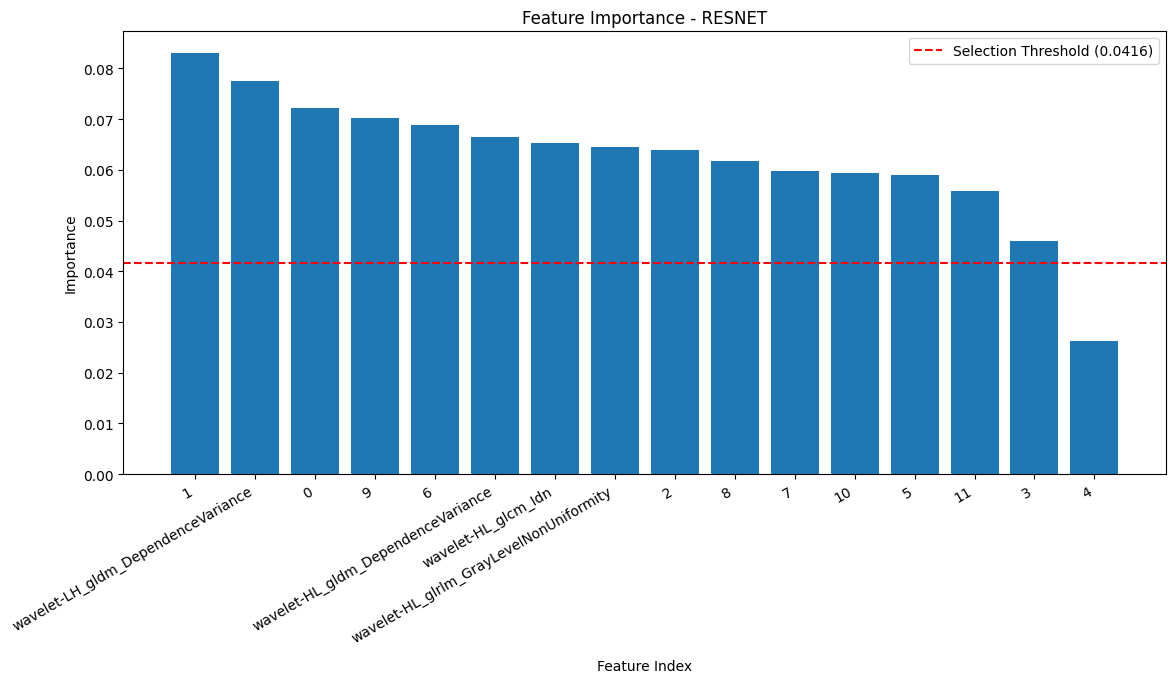

Classifier: ensemble
Numero features: 15
F1 Score: 0.6667
ROC AUC: 0.8673
PR AUC: 0.8323
Accuracy: 0.7949
Balanced Accuracy: 0.7593
Best Threshold: 0.5
Confusion Matrix (Test):
[[23  4]
 [ 4  8]]


In [429]:
import re


match = re.search(r'selected_features_combined_(.*?)_Rad.csv', file_path)
if(match.group(1) == 'INCRES'):
    nome_grafico = 'INCEPTION RESNET'
else:
    nome_grafico =match.group(1)

classifiers = ["SVM", "RandomForest", "MLP", "XgBoost", 'ensemble', 'Logistic']
#classifiers = ["SVM"]
best_classifier = None
best_results = None

# Variabili per memorizzare il miglior punteggio
best_balanced_accuracy = -1
best_roc_auc = -1

# Loop su ciascun classificatore
for classifier in classifiers:
    print(f"\n--- Risultati per {classifier} (Validation) ---")
    
    # Risultati sul validation set
    results = classification_method_features_fixed(classifier, X_train, Y_train, X_val, y_val)
    
    # Verifica se questo classificatore ha la migliore balanced accuracy
    if results['balanced_accuracy'] > best_balanced_accuracy:
        best_balanced_accuracy = results['balanced_accuracy']
        best_roc_auc = results['roc_auc']  # Aggiorna anche ROC AUC
        best_classifier = classifier
        best_results = results
    # In caso di parità sulla balanced accuracy, guarda la ROC AUC
    elif results['balanced_accuracy'] == best_balanced_accuracy and results['roc_auc'] > best_roc_auc:
        best_roc_auc = results['roc_auc']
        best_classifier = classifier
        best_results = results

# Miglior classificatore trovato
print(f"\n--- Miglior classificatore: {best_classifier} ---")
print(f"Balanced Accuracy: {best_results['balanced_accuracy']:.4f}")
print(f"ROC AUC: {best_results['roc_auc']:.4f}")
print(f"F1 Score: {best_results['f1']:.4f}")
print(f"Confusion Matrix (Validation):\n{best_results['confusion_matrix']}")

# Test senza feature importance
print(f"\n--- Risultati per {best_classifier} (Test senza feature importance) ---")
results_no_importance = classification_method_features_fixed(best_classifier, X_train1, Y_train1, X_test, y_test)

# Stampa i risultati finali sul test set (senza feature importance)
print(f"Classifier: {results_no_importance['classifier']}")
print(f"Numero features: {X_train1.shape[1]}")
print(f"F1 Score: {results_no_importance['f1']:.4f}")
print(f"ROC AUC: {results_no_importance['roc_auc']:.4f}")
print(f"PR AUC: {results_no_importance['pr_auc']:.4f}")
print(f"Accuracy: {results_no_importance['accuracy']:.4f}")
print(f"Balanced Accuracy: {results_no_importance['balanced_accuracy']:.4f}")
print(f"Best Threshold: {results_no_importance['best_threshold']}")
print(f"Confusion Matrix (Test):\n{results_no_importance['confusion_matrix']}")

# Test con feature importance (RandomForest come default se il classificatore non ha feature importance)
print(f"\n--- Risultati per {best_classifier} (Test con feature importance) ---")
if hasattr(classifierinitialization(best_classifier).fit(X_train1, Y_train1), 'feature_importances_'):
    results_importance = classification_method_features_fixed_importance('RandomForest', best_classifier, X_train1, Y_train1, X_test, y_test, df, nome_grafico)
else:
    print(f"\nIl classificatore {best_classifier} non supporta le feature importance. Userò RandomForest.")
    results_importance = classification_method_features_fixed_importance('RandomForest',best_classifier, X_train1, Y_train1, X_test, y_test, df, nome_grafico)

# Stampa i risultati finali sul test set (con feature importance)
print(f"Classifier: {results_importance['classifier']}")
print(f"Numero features: {results_importance['number_features']}")
print(f"F1 Score: {results_importance['f1']:.4f}")
print(f"ROC AUC: {results_importance['roc_auc']:.4f}")
print(f"PR AUC: {results_importance['pr_auc']:.4f}")
print(f"Accuracy: {results_importance['accuracy']:.4f}")
print(f"Balanced Accuracy: {results_importance['balanced_accuracy']:.4f}")
print(f"Best Threshold: {results_importance['best_threshold']}")
print(f"Confusion Matrix (Test):\n{results_importance['confusion_matrix']}")



--- Risultati per SVM (Validation) ---

--- Risultati per RandomForest (Validation) ---

--- Risultati per MLP (Validation) ---

--- Risultati per XgBoost (Validation) ---

--- Risultati per ensemble (Validation) ---

--- Risultati per Logistic (Validation) ---

--- Miglior classificatore: RandomForest ---
Balanced Accuracy: 0.7000
ROC AUC: 0.7583
F1 Score: 0.6667
Confusion Matrix (Validation):
[[11  4]
 [ 4  8]]


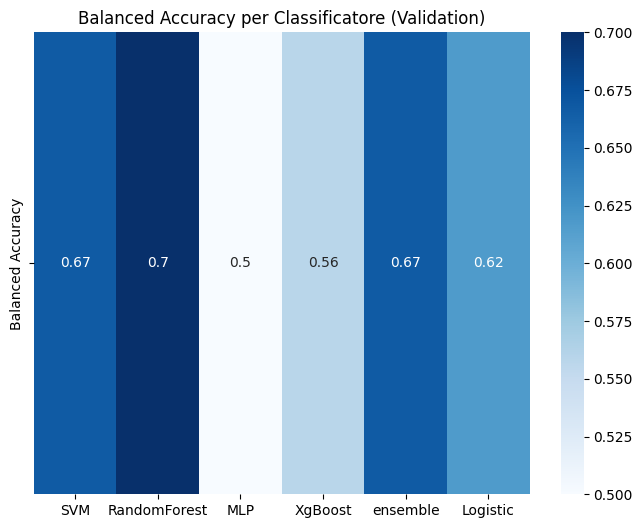

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Lista per memorizzare i risultati delle balanced accuracy
classifier_results = []

# Loop su ciascun classificatore
for classifier in classifiers:
    print(f"\n--- Risultati per {classifier} (Validation) ---")
    
    # Risultati sul validation set
    results = classification_method_features_fixed(classifier, X_train, Y_train, X_val, y_val)
    
    # Aggiungi i risultati alla lista
    classifier_results.append({
        'classifier': classifier,
        'balanced_accuracy': results['balanced_accuracy']
    })
    
    # Verifica se questo classificatore ha la migliore balanced accuracy
    if results['balanced_accuracy'] > best_balanced_accuracy:
        best_balanced_accuracy = results['balanced_accuracy']
        best_roc_auc = results['roc_auc']  # Aggiorna anche ROC AUC
        best_classifier = classifier
        best_results = results
    # In caso di parità sulla balanced accuracy, guarda la ROC AUC
    elif results['balanced_accuracy'] == best_balanced_accuracy and results['roc_auc'] > best_roc_auc:
        best_roc_auc = results['roc_auc']
        best_classifier = classifier
        best_results = results

# Miglior classificatore trovato
print(f"\n--- Miglior classificatore: {best_classifier} ---")
print(f"Balanced Accuracy: {best_results['balanced_accuracy']:.4f}")
print(f"ROC AUC: {best_results['roc_auc']:.4f}")
print(f"F1 Score: {best_results['f1']:.4f}")
print(f"Confusion Matrix (Validation):\n{best_results['confusion_matrix']}")

# Estrai solo le balanced accuracy per la heatmap
classifiers_names = [item['classifier'] for item in classifier_results]
balanced_accuracies = [item['balanced_accuracy'] for item in classifier_results]

# Crea la heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    np.array(balanced_accuracies).reshape(1, -1), 
    annot=True, 
    cmap="Blues", 
    xticklabels=classifiers_names,
    yticklabels=["Balanced Accuracy"]
)
plt.title("Balanced Accuracy per Classificatore (Validation)")
plt.show()


### Utilizzo lo stesso numero di features / alpha sul test

In [76]:
# Classificatori e selettori per ciascun caso
classi_rad = "RandomForest"
classi_vgg = "SVM"
classi_res = "SVM"
classi_inc = "SVM"

selector_rad = "logistic"
selector_vgg = "mrmr"
selector_res = "rf"
selector_inc = "lasso"

alpha_res_inc = np.linspace(0.001, 0.5, 30).tolist()

# Alpha e numero massimo di features da provare
alpha_values = alpha_res_inc  # Esempio per Lasso
max_features = X_train.shape[1]  # Numero massimo di features per gli altri selector
print(max_features)
# Inizializza i dizionari per salvare i risultati
results_val = []
results_test = []

# Specifica quale rete pretrainata vuoi provare
rete_pretrainata = "inc"  # Puoi cambiare tra 'vgg', 'rad', 'inc', 'res'

# Seleziona le combinazioni in base alla rete pretrainata specificata
if rete_pretrainata == "vgg":
    combinazioni = [
        (classi_vgg, selector_vgg),
        (classi_vgg, selector_rad),
        (classi_rad, selector_vgg),
        (classi_rad, selector_rad),
    ]
elif rete_pretrainata == "inc":
    combinazioni = [
        (classi_rad, selector_rad),
        (classi_rad, selector_inc),
        (classi_inc, selector_rad),
        (classi_inc, selector_inc)
    ]

elif rete_pretrainata == "res":
    combinazioni = [
        (classi_res, selector_res),
        (classi_res, selector_rad),
        (classi_rad, selector_res),
        (classi_rad, selector_rad),
    ]
else:
    print("Rete pretrainata non riconosciuta.")
    exit()

# Cicla su tutte le combinazioni di classifier e selector
for classi, selector in combinazioni:
    print(f"\n--- Prova combinazione: {classi} con {selector} ---")

    if selector == "lasso":
        # Cicla sui valori di alpha per Lasso
        for alpha in alpha_values:
            best_case_val = classification_method_selector_fixed(
                classi, selector, X_train, Y_train, X_val, y_val, alpha=alpha, num_features=None, mode='selector'
            )
            if best_case_val == 0:
                best_case_val['balanced accuracy'] = 0
                best_case_val['accuracy'] = 0
                best_case_val['f1'] = 0
                best_case_val['roc_auc'] = 0
                best_case_val['pr_auc'] = 0
                best_case_val['selected_features'] = [0]
                best_case_val['num_features'] = 0
                best_case_val['confusion_matrix'] = 0
            #print(alpha)
            #print(len(best_case_val['selected_features']))
            results_val.append({
                'classifier': classi,
                'selector': selector,
                'alpha': alpha,
                'num_features': len(best_case_val['selected_features']),
                'selected_features': best_case_val['selected_features'],
                'pr_auc': best_case_val['pr_auc'],
                'roc_auc': best_case_val['roc_auc'],
                'f1': best_case_val['f1'],
                'accuracy': best_case_val['accuracy'],
                'balanced_accuracy': best_case_val['balanced_accuracy'],
                'confusion_matrix': best_case_val['confusion_matrix']
            })

    else:
        # Cicla sul numero di feature per gli altri selector
        for num_features in range(1, max_features + 1):

            best_case_val = classification_method_selector_fixed(
                classi, selector, X_train, Y_train, X_val, y_val, alpha=0, num_features=num_features, mode='selector'
            )
            results_val.append({
                'classifier': classi,
                'selector': selector,
                'alpha': 0,
                'num_features': len(best_case_val['selected_features']),
                'selected_features': best_case_val['selected_features'],
                'pr_auc': best_case_val['pr_auc'],
                'roc_auc': best_case_val['roc_auc'],
                'f1': best_case_val['f1'],
                'accuracy': best_case_val['accuracy'],
                'balanced_accuracy': best_case_val['balanced_accuracy'],
                'confusion_matrix': best_case_val['confusion_matrix']
            })

# Trova la miglior combinazione sulla validation per balanced_accuracy
best_combination = max(results_val, key=lambda x: x['balanced_accuracy'])

# Stampa il miglior risultato per validation
print(f"\nMiglior combinazione per {rete_pretrainata}: Classifier {best_combination['classifier']} con selector {best_combination['selector']} e num features {best_combination['num_features']}")
print(f"Balanced Accuracy: {best_combination['balanced_accuracy']:.4f}")
print(f"F1 Score: {best_combination['f1']:.4f}")
print(f"ROC AUC: {best_combination['roc_auc']:.4f}")
print(f"PR AUC: {best_combination['pr_auc']:.4f}")
print(f"Confusion Matrix:\n{best_combination['confusion_matrix']}")

# Allena la miglior combinazione su train + validation e testa su test set
classi_init = best_combination['classifier']
best_case_test = classification_method_selector_fixed(
    classi_init, best_combination['selector'], X_train1, Y_train1, X_test, y_test,
    alpha=best_combination['alpha'], num_features=best_combination['num_features'], mode='selector'
)

# Stampa i risultati su test set
print("\n--- Risultati su Test ---")
print(f"Numero Features: {len(best_case_test['selected_features'])}")
print(f"Numero Features: {best_case_test['selected_features']}")
print(f"Balanced Accuracy: {best_case_test['balanced_accuracy']:.4f}")
print(f"F1 Score: {best_case_test['f1']:.4f}")
print(f"ROC AUC: {best_case_test['roc_auc']:.4f}")
print(f"PR AUC: {best_case_test['pr_auc']:.4f}")
print(f"Confusion Matrix:\n{best_case_test['confusion_matrix']}")


26

--- Prova combinazione: RandomForest con logistic ---

--- Prova combinazione: RandomForest con lasso ---

--- Prova combinazione: SVM con logistic ---

--- Prova combinazione: SVM con lasso ---

Miglior combinazione per inc: Classifier RandomForest con selector logistic e num features 14
Balanced Accuracy: 0.9000
F1 Score: 0.8889
ROC AUC: 0.9056
PR AUC: 0.8585
Confusion Matrix:
[[12  3]
 [ 0 12]]

--- Risultati su Test ---
Numero Features: 14
Numero Features: [ 5 10 19 16 15 20  3  8 14 13 11 12 21  9]
Balanced Accuracy: 0.6250
F1 Score: 0.5000
ROC AUC: 0.6281
PR AUC: 0.3581
Confusion Matrix:
[[18  9]
 [ 5  7]]


### Utilizzo le stesse features sul test

In [77]:
classi_rad = "RandomForest"
classi_vgg = "SVM"
classi_res = "SVM"
classi_inc = "SVM"

selector_rad = "logistic"
selector_vgg = "mrmr"
selector_res = "rf"
selector_inc = "lasso"

alpha_res_inc = np.linspace(0.001, 0.5, 30).tolist()

# Alpha e numero massimo di features da provare
alpha_values = alpha_res_inc  # Esempio per Lasso
max_features = X_train.shape[1]  # Numero massimo di features per gli altri selector
print(max_features)
# Inizializza i dizionari per salvare i risultati
results_val = []
results_test = []

# Specifica quale rete pretrainata vuoi provare
rete_pretrainata = "inc"  # Puoi cambiare tra 'vgg', 'rad', 'inc', 'res'

# Seleziona le combinazioni in base alla rete pretrainata specificata
if rete_pretrainata == "vgg":
    combinazioni = [
        (classi_vgg, selector_vgg),
        (classi_vgg, selector_rad),
        (classi_rad, selector_vgg),
        (classi_rad, selector_rad),
    ]
elif rete_pretrainata == "inc":
    combinazioni = [
        (classi_rad, selector_rad),
        (classi_rad, selector_inc),
        (classi_inc, selector_rad),
        (classi_inc, selector_inc)
    ]

elif rete_pretrainata == "res":
    combinazioni = [
        (classi_res, selector_res),
        (classi_res, selector_rad),
        (classi_rad, selector_res),
        (classi_rad, selector_rad),
    ]
else:
    print("Rete pretrainata non riconosciuta.")
    exit()

# Cicla su tutte le combinazioni di classifier e selector
for classi, selector in combinazioni:
    print(f"\n--- Prova combinazione: {classi} con {selector} ---")

    if selector == "lasso":
        # Cicla sui valori di alpha per Lasso
        for alpha in alpha_values:
            best_case_val = classification_method_selector_fixed(
                classi, selector, X_train, Y_train, X_val, y_val, alpha=alpha, num_features=None, mode='selector'
            )
            if best_case_val == 0:
                best_case_val['balanced accuracy'] = 0
                best_case_val['accuracy'] = 0
                best_case_val['f1'] = 0
                best_case_val['roc_auc'] = 0
                best_case_val['pr_auc'] = 0
                best_case_val['selected_features'] = [0]
                best_case_val['num_features'] = 0
                best_case_val['confusion_matrix'] = 0
            
            results_val.append({
                'classifier': classi,
                'selector': selector,
                'alpha': alpha,
                'num_features': len(best_case_val['selected_features']),
                'selected_features': best_case_val['selected_features'],
                'pr_auc': best_case_val['pr_auc'],
                'roc_auc': best_case_val['roc_auc'],
                'f1': best_case_val['f1'],
                'accuracy': best_case_val['accuracy'],
                'balanced_accuracy': best_case_val['balanced_accuracy'],
                'confusion_matrix': best_case_val['confusion_matrix']
            })

    else:
        # Cicla sul numero di feature per gli altri selector
        for num_features in range(1, max_features + 1):

            best_case_val = classification_method_selector_fixed(
                classi, selector, X_train, Y_train, X_val, y_val, alpha=0, num_features=num_features, mode='selector'
            )
            results_val.append({
                'classifier': classi,
                'selector': selector,
                'alpha': 0,
                'num_features': len(best_case_val['selected_features']),
                'selected_features': best_case_val['selected_features'],
                'pr_auc': best_case_val['pr_auc'],
                'roc_auc': best_case_val['roc_auc'],
                'f1': best_case_val['f1'],
                'accuracy': best_case_val['accuracy'],
                'balanced_accuracy': best_case_val['balanced_accuracy'],
                'confusion_matrix': best_case_val['confusion_matrix']
            })

# Trova la miglior combinazione sulla validation per balanced_accuracy
best_combination = max(results_val, key=lambda x: x['balanced_accuracy'])

# Stampa il miglior risultato per validation
print(f"\nMiglior combinazione per {rete_pretrainata}: Classifier {best_combination['classifier']} con selector {best_combination['selector']} e num features {best_combination['num_features']}")
print(f"Balanced Accuracy: {best_combination['balanced_accuracy']:.4f}")
print(f"F1 Score: {best_combination['f1']:.4f}")
print(f"ROC AUC: {best_combination['roc_auc']:.4f}")
print(f"PR AUC: {best_combination['pr_auc']:.4f}")
print(f"Confusion Matrix:\n{best_combination['confusion_matrix']}")

# Allena la miglior combinazione su train + validation e testa su test set
classi_init = best_combination['classifier']
best_case_test = classification_method_selector_fixed(
    classi_init, best_combination['selector'], X_train1, Y_train1, X_test, y_test,
    alpha=best_combination['alpha'], num_features=best_combination['num_features'], mode='features', selected_features=best_combination['selected_features']
)

# Stampa i risultati su test set
print("\n--- Risultati su Test ---")
print(f"Numero Features: {len(best_case_test['selected_features'])}")
print(f"Numero Features: {best_case_test['selected_features']}")
print(f"Balanced Accuracy: {best_case_test['balanced_accuracy']:.4f}")
print(f"F1 Score: {best_case_test['f1']:.4f}")
print(f"ROC AUC: {best_case_test['roc_auc']:.4f}")
print(f"PR AUC: {best_case_test['pr_auc']:.4f}")
print(f"Confusion Matrix:\n{best_case_test['confusion_matrix']}")


26

--- Prova combinazione: RandomForest con logistic ---

--- Prova combinazione: RandomForest con lasso ---

--- Prova combinazione: SVM con logistic ---

--- Prova combinazione: SVM con lasso ---

Miglior combinazione per inc: Classifier RandomForest con selector logistic e num features 14
Balanced Accuracy: 0.9000
F1 Score: 0.8889
ROC AUC: 0.9056
PR AUC: 0.8585
Confusion Matrix:
[[12  3]
 [ 0 12]]

--- Risultati su Test ---
Numero Features: 14
Numero Features: [10  5 18 19 20 15 16  3 12 21 13 11  2  9]
Balanced Accuracy: 0.5880
F1 Score: 0.4667
ROC AUC: 0.6651
PR AUC: 0.3964
Confusion Matrix:
[[16 11]
 [ 5  7]]
